# Analyze your Personal Netflix Data

**How much time have I spent watching Netlix? Which shows are the most time-consuming? Is it worth it?**

Netflix allows to download account data. With a just a little Python and pandas programming, we can get concrete answers to these questions and more. 

## Download Netflix Data
To get your own Netflix data, submit a request via [this](https://www.netflix.com/account/getmyinfo) link, or simply click on `Download your personal information` from your own account page. Netflix will prepare a data report that can take up to 30 days, but it is often the case that the data are made available the next (couple of) day(s). 

## Get to Know your Netflix Data
Understanding data is the most fundamental step of every analysis. Unzipping the file leads to the following: 

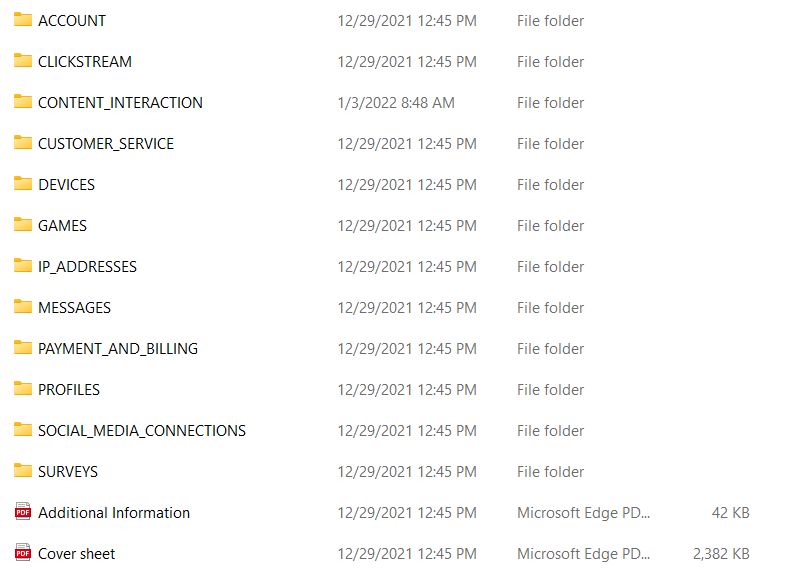

Our goal is to figure out how much time I've spent watching Netflix. Content Interaction seems like the most likely folder to contain that data. If we open it, we'll find a file called `ViewingActivity.csv` that looks exactly like what we want — a log of everything we've viewed over the history of the account.

There's a file called `Cover sheet.pdf` that contains data dictionaries for all of the `.csv` files. This data dictionary can help us answer questions and avoid errors.

## Load your Data into Yupyter Notebook

Let us start by importing the the most common libraries for basic data analysis and visualization, such as `pandas` and `matplotlib`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the Netflix data into a dataframe called `netflix`
netflix = pd.read_csv('ViewingActivity.csv')
netflix.head(1)

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Evis,12/28/2021 13:02,0:00:02,Autoplayed: user action: None;,Modern Family: Season 6: Marco Polo (Episode 4),NaN,Chrome PC (Cadmium),0:00:03,0:00:03,AL (Albania)


We can extract basic information regarding the data by calling the method `info()`, which allows us to quickly observe that in this case the dataset contains 1400 records which hold information about key elements for our analysis such as:
- `Start time`, i.e., the starting time of watching a particular episode
- `Duration`, i.e., the length of watching for a particular sessions
- `Title` denoting the full title of the show/movie (e.g., including also season and episode number in case of a show)

and other information, such as `Profile Name`, `Attributes`, `Supplemental Video Type`, `Device Type`,`Bookmark`, `Latest Bookmark`, `Country` which are not relevant for our analysis. For a full decription of the data refer to the `Cover_Sheet` document 

In [3]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Profile Name             1400 non-null   object
 1   Start Time               1400 non-null   object
 2   Duration                 1400 non-null   object
 3   Attributes               286 non-null    object
 4   Title                    1400 non-null   object
 5   Supplemental Video Type  205 non-null    object
 6   Device Type              1400 non-null   object
 7   Bookmark                 1400 non-null   object
 8   Latest Bookmark          1400 non-null   object
 9   Country                  1400 non-null   object
dtypes: object(10)
memory usage: 109.5+ KB


## Preparing Data for Analysis
### Dropping Unnecessary Columns
First, we'll start by dropping the columns we're not planning to use. In this case, we're planning to analyze how much and when we watched certain shows, so we'll need to keep the `Start Time`, `Duration`, and `Title` columns. Everything else can go.

**Disclaimer: deleting data is not a good idea, however for this particular simple project we're only interested in a portion of our data**

In [4]:
netflix = netflix.drop(['Profile Name', 'Attributes', 'Supplemental Video Type', 
                        'Device Type', 'Bookmark', 'Latest Bookmark', 'Country'], axis=1)
netflix.head(1)

,Start Time,Duration,Title
0,12/28/2021 13:02,0:00:02,Modern Family: Season 6: Marco Polo (Episode 4)


### Converting Strings to Datetime and Timedelta in Pandas
As we observed when calling the `info()` method, all three columns are stored as of type `object`. That's fine for the `Title` column, but we need to change the two time-related columns into the correct datatypes before we can work with them.

Specifically, we need to do the following:

- Convert `Start Time` to `datetime` (a data and time format pandas can understand and perform calculations with)
- Convert `Start Time` from UTC to our local timezone
- Convert `Duration` to `timedelta` (a time duration format pandas can understand and perform calculations with)

In [5]:
#We'll also add the optional argument utc=True so that our datetime data has the UTC timezone attached to it. 
#This is important, since we'll need to convert it to a different timezone in the next step.
netflix['Start Time'] = pd.to_datetime(netflix['Start Time'], utc=True)
netflix.dtypes

Start Time    datetime64[ns, UTC]
Duration                   object
Title                      object
dtype: object

We can convert datetimes to any timezone using the `.tz_convert()` and passing it an argument with the string for the timezone we want to convert to. In this case, that's `Europe/Tirane`. To find your specific timezone, [here's a handy reference of TZ timezone options.](https://en.wikipedia.org/wiki/List_of_tz_database_time_zones)

The tricky bit here is that we can only use `.tz_convert()` on a `DatetimeIndex`, so we need to set our `Start Time` column as the index using `set_index()` before we perform the conversion.

In this tutorial, we'll then use `reset_index()` to turn it back into a regular column afterwards

Putting all of that together looks like this:

In [6]:
# change the Start Time column into the dataframe's index
netflix = netflix.set_index('Start Time')
# convert from UTC timezone to Tirana time
netflix.index = netflix.index.tz_convert('Europe/Tirane')
# reset the index so that Start Time becomes a column again
netflix = netflix.reset_index()
#double-check that it worked
netflix.head(1)

,Start Time,Duration,Title
0,2021-12-28 14:02:00+01:00,0:00:02,Modern Family: Season 6: Marco Polo (Episode 4)


Now, let's deal with our `Duration` column. This is, as the name suggests, a duration — a measure of a length of time. So, rather than converting it to a datetime, we need to convert it to a timedelta, which is a measure of time duration that pandas understands.

In [7]:
netflix['Duration'] = pd.to_timedelta(netflix['Duration'])
netflix.dtypes

Start Time    datetime64[ns, Europe/Tirane]
Duration                    timedelta64[ns]
Title                                object
dtype: object

## Analyzing Netflix Data

### How much Netflix have I watched? 
To provide a relevant context for this question, we can observe the date of the first and the last session watched. 

In [8]:
# the earliest time 
netflix['Start Time'].min()

Timestamp('2020-04-24 22:16:00+0200', tz='Europe/Tirane')

In [9]:
# the latest time 
netflix['Start Time'].max()

Timestamp('2021-12-28 14:02:00+0100', tz='Europe/Tirane')

In [10]:
# timeframe
timeframe = netflix['Start Time'].max() - netflix['Start Time'].min()
timeframe

Timedelta('612 days 16:46:00')

In [11]:
# total watch time
total_watch_time = netflix['Duration'].sum()
total_watch_time

Timedelta('14 days 21:24:41')

For a period of approximately 20 months, I have watched overall almost 15 days of Netflix. **Before judging make sure to do the analysis on your own data first :)**

![info](https://media.giphy.com/media/MuJDYvbYKzMwONKvdO/giphy.gif)

To be more accurate, we can calculate how much time, on average, I spend each day watching Netflix

In [12]:
hours_in_day = 24
minutes_in_hour = 60
avg_watch_time_per_day = total_watch_time / timeframe * hours_in_day * minutes_in_hour
avg_watch_time_per_day

35.00037856205358

Well, well, **35 minutes per day, on average**, doesn't look so bad

### How much time have I spent watching my favorite TV show?

One of the longest shows I've watched on Netflix is `The Blacklist` (too many seasons, I know).

![blacklist](https://media.giphy.com/media/fVVzjLZCupAOV6oUdi/giphy.gif)

For simplicity, lets create a new dataframe populated only with rows containing information about the `The Blacklist`. 

In [13]:
# create a new dataframe called the_blacklist that that contains
# only the rows in which the Title column contains 'The Blacklist'
the_blacklist = netflix[netflix['Title'].str.contains('The Blacklist', regex=False)]

In [14]:
#inspect random rows of the new dataframe
the_blacklist.sample(10)

,Start Time,Duration,Title
1054,2020-08-29 13:07:00+02:00,0 days 00:34:00,The Blacklist: Season 2: Luther Braxton (No. 2...
994,2020-09-10 13:47:00+02:00,0 days 00:39:41,The Blacklist: Season 3: The Caretaker (No. 78...
1102,2020-08-08 13:49:00+02:00,0 days 00:23:51,The Blacklist: Season 1: The Courier (No. 85) ...
959,2020-09-17 13:18:00+02:00,0 days 00:10:26,The Blacklist: Season 4: Dr. Adrian Shaw (No. ...
917,2020-09-24 13:02:00+02:00,0 days 00:02:18,The Blacklist: Season 5: Miss Rebecca Thrall (...
1029,2020-09-03 10:19:00+02:00,0 days 00:08:03,The Blacklist: Season 2: Quon Zhang (No. 87) (...
888,2020-10-01 13:57:00+02:00,0 days 00:00:13,The Blacklist: Season 1_hook_primary_16x9
1083,2020-08-25 13:47:00+02:00,0 days 00:00:02,The Blacklist: Season 1: The Judge (No. 57) (E...
922,2020-09-23 13:56:00+02:00,0 days 00:37:31,The Blacklist: Season 4: Mr. Kaplan (No. 4): C...
835,2020-10-10 20:26:00+02:00,0 days 00:03:56,The Blacklist: Season 6: Bastien Moreau (no. 2...


First, let's answer the big question: How much time have I spent watching The Blacklist?

In [15]:
the_blacklist['Duration'].sum()

Timedelta('5 days 01:26:49')

### When do I watch 'The Blacklist'?

Let's answer this question in two different ways:

- On which days of the week have I watched the most episodes?
- During which hours of the day do I most often start to watch episodes?

We'll start with a little prep work that'll make these tasks a little more straightforward: creating new columns for `weekday` and `hour`.

In [16]:
the_blacklist['weekday'] = the_blacklist['Start Time'].dt.weekday
the_blacklist['hour']    = the_blacklist['Start Time'].dt.hour

# check to make sure the columns were added correctly
the_blacklist.head(1)

<ipython-input-16-b555b3452db4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_blacklist['weekday'] = the_blacklist['Start Time'].dt.weekday
<ipython-input-16-b555b3452db4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_blacklist['hour']    = the_blacklist['Start Time'].dt.hour


,Start Time,Duration,Title,weekday,hour
212,2021-10-25 13:24:00+02:00,0 days 00:42:15,The Blacklist: Season 9: The Skinner (No. 45) ...,0,13


Now, let's plot a chart of my viewing habits by day of the week. To do this, we'll need to work through a few steps:

- Tell pandas the order we want to chart the days in using `pd.Categorical` — by default, it will plot them in descending order based on the number of episodes watched on each day, but when looking at a graph, it'll be more intuitive to see the data in Monday-Sunday order.
- Count the number of episodes I viewed on each day in total
- Sort and plot the data

<ipython-input-17-811a70697b8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_blacklist['weekday'] = pd.Categorical(the_blacklist['weekday'], categories= [0,1,2,3,4,5,6], ordered=True)


<AxesSubplot:title={'center':'The Blacklist Episodes Watched by Day'}>

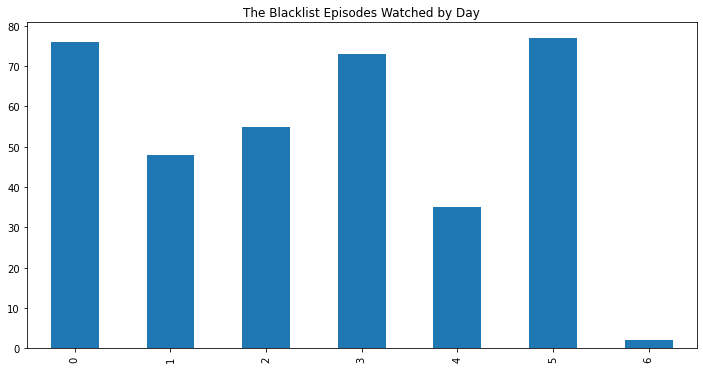

In [17]:
# set our categorical and define the order so the days are plotted Monday-Sunday
the_blacklist['weekday'] = pd.Categorical(the_blacklist['weekday'], categories= [0,1,2,3,4,5,6], ordered=True)

# create the_blacklist_by_day and count the rows for each weekday, assigning the result to that variable
the_blacklist_by_day = the_blacklist['weekday'].value_counts()

# sort the index using our categorical, so that Monday (0) is first, Tuesday (1) is second, etc.
the_blacklist_by_day = the_blacklist_by_day.sort_index()

# plot the_blacklist_by_day as a bar chart with the listed size and title
the_blacklist_by_day.plot(kind='bar', figsize=(12,6), title='The Blacklist Episodes Watched by Day')

Now, let's take a look at the same data by hour. The process here is very similar to what we just did above:

<ipython-input-18-a72dc6427cbc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_blacklist['hour'] = pd.Categorical(the_blacklist['hour'],


<AxesSubplot:title={'center':'The Blacklist Episodes Watched by Hour'}>

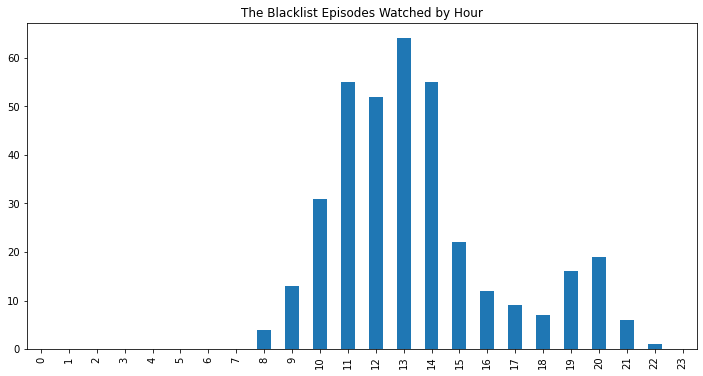

In [18]:
# set our categorical and define the order so the hours are plotted 0-23
the_blacklist['hour'] = pd.Categorical(the_blacklist['hour'], 
                                       categories= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], 
                                       ordered=True)

# create the_blacklist_by_hour and count the rows for each hour, assigning the result to that variable
the_blacklist_by_hour = the_blacklist['hour'].value_counts()

# sort the index using our categorical, so that midnight (0) is first, 1 a.m. (1) is second, etc.
the_blacklist_by_hour = the_blacklist_by_hour.sort_index()

# plot the_blacklist_by_hour as a bar chart with the listed size and title
the_blacklist_by_hour.plot(kind='bar', figsize=(12,6), title='The Blacklist Episodes Watched by Hour')

Bad habits, I know - watching tv shows during working hours is not a thing to be proud. In my defense, I use that as a midday break to boost productivity (or at least I like to think it that way).  
![work_day](https://media.giphy.com/media/XymXANrzgI4k6FL6zr/giphy.gif)

You can give it a try with your own data and further expand this simple analysis in any way you like. 